### Group Prject - London Bike Rentals

In this project, you will work with the London Bikes dataset, which records daily bike rentals in the city along with key variables such as dates, weather conditions, and seasonality.

The goal is to apply the full data analytics workflow:

- Clean and prepare the dataset.

- Explore the data through visualisation.

- Construct and interpret confidence intervals.

- Build a regression model to explain variation in bike rentals.

- By the end, you will connect statistical concepts with practical Python analysis.

In [2]:
## Import libraries and data

## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

bikes= pd.read_csv('../Data/london_bikes.csv')
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend
0,2010-07-30T00:00:00Z,6897,2010,Fri,Jul,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False
1,2010-07-31T00:00:00Z,5564,2010,Sat,Jul,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True
2,2010-08-01T00:00:00Z,4303,2010,Sun,Aug,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True
3,2010-08-02T00:00:00Z,6642,2010,Mon,Aug,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False
4,2010-08-03T00:00:00Z,7966,2010,Tue,Aug,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False


**1. Data Cleaning**

Check for missing values across columns. How would you handle them?

Inspect the date column and ensure it is correctly formatted as datetime. Extract useful features (year, month, day, day of week, season).

Convert categorical variables (e.g., season, weather) to appropriate categories in Python.

Ensure numeric columns (e.g., bikes rented, temperature) are in the right format.

In [3]:
## Your code goes here

bikes.info()

#convert date column to datetime format
bikes["date"] = pd.to_datetime(
    bikes["date"],
    format="%Y-%m-%dT%H:%M:%SZ",
    errors="coerce",
    utc=True
)

bikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4934 non-null   object 
 1   bikes_hired    4934 non-null   int64  
 2   year           4934 non-null   int64  
 3   wday           4934 non-null   object 
 4   month          4934 non-null   object 
 5   week           4934 non-null   int64  
 6   cloud_cover    4901 non-null   float64
 7   humidity       4851 non-null   float64
 8   pressure       4903 non-null   float64
 9   radiation      4894 non-null   float64
 10  precipitation  4903 non-null   float64
 11  snow_depth     4632 non-null   float64
 12  sunshine       4903 non-null   float64
 13  mean_temp      4903 non-null   float64
 14  min_temp       4872 non-null   float64
 15  max_temp       4903 non-null   float64
 16  weekend        4934 non-null   bool   
dtypes: bool(1), float64(10), int64(3), object(3)
memory 

In [4]:
#Convert Months into sorted category
bikes["month"] = pd.Categorical(
    bikes["date"].dt.month_name(),
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

In [5]:
bikes.isna().sum()

date               0
bikes_hired        0
year               0
wday               0
month              0
week               0
cloud_cover       33
humidity          83
pressure          31
radiation         40
precipitation     31
snow_depth       302
sunshine          31
mean_temp         31
min_temp          62
max_temp          31
weekend            0
dtype: int64

In [6]:
#We suggest dropping the na values in humidity, pressure, radiation, mean_temp, min_temp, max_temp completely
#Then we want to substitute the other values with 0

drop_na_subset = ["humidity", "pressure", "radiation", 
                "mean_temp", "min_temp", "max_temp"]
fill_zero_subset = ["cloud_cover", "precipitation", 
                  "snow_depth", "sunshine"]

bikes = bikes.dropna(subset=drop_na_subset)
bikes[fill_zero_subset] = bikes[fill_zero_subset].fillna(0)

In [7]:
#Extract season based on month (northern hemisphere in London)
conditions = [
    bikes["date"].dt.month.isin([12, 1, 2]),
    bikes["date"].dt.month.isin([3, 4, 5]),
    bikes["date"].dt.month.isin([6, 7, 8]),
    bikes["date"].dt.month.isin([9, 10, 11]),
]
choices = ["Winter", "Spring", "Summer", "Autumn"]
bikes["season"] = np.select(conditions, choices, default = 'Unknown')
bikes["season"] = pd.Categorical(
    bikes["season"],
    categories=["Winter", "Spring", "Summer", "Autumn"],
    ordered=True
)
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend,season
0,2010-07-30 00:00:00+00:00,6897,2010,Fri,July,30,6.0,65.0,10147.0,157.0,22.0,0.0,31.0,17.7,12.3,25.1,False,Summer
1,2010-07-31 00:00:00+00:00,5564,2010,Sat,July,30,5.0,70.0,10116.0,184.0,0.0,0.0,47.0,21.1,17.0,23.9,True,Summer
2,2010-08-01 00:00:00+00:00,4303,2010,Sun,August,30,7.0,63.0,10132.0,89.0,0.0,0.0,3.0,19.3,14.6,23.4,True,Summer
3,2010-08-02 00:00:00+00:00,6642,2010,Mon,August,31,7.0,59.0,10168.0,134.0,0.0,0.0,20.0,19.5,15.6,23.6,False,Summer
4,2010-08-03 00:00:00+00:00,7966,2010,Tue,August,31,5.0,66.0,10157.0,169.0,0.0,0.0,39.0,17.9,12.1,20.1,False,Summer


**2. Exploratory Data Analysis (EDA)**

Plot the distribution of bikes rented.

Explore how rentals vary by season and month.

Investigate the relationship between temperature and bikes rented.

**Deliverables:**

At least 3 clear visualisations with captions.

A short written interpretation of key patterns (seasonality, weather effects, etc.).



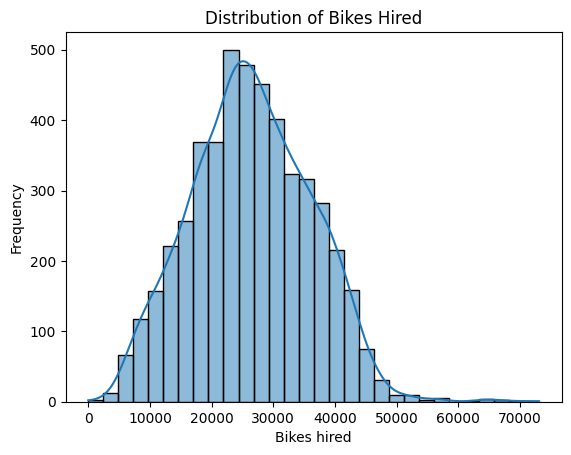

In [8]:
## Your code goes here
sns.histplot(bikes["bikes_hired"], bins=30, kde=True)
plt.title("Distribution of Bikes Hired")
plt.xlabel("Bikes hired")
plt.ylabel("Frequency")
plt.show()

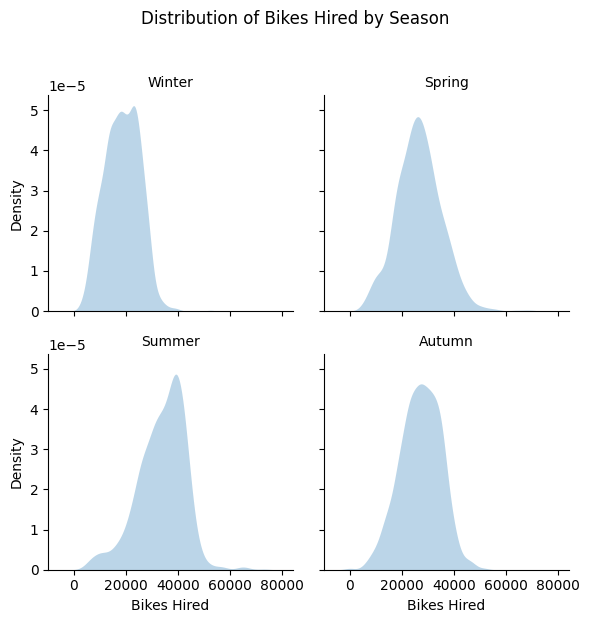

In [9]:
#rentals vary by season

g = sns.FacetGrid(bikes, col="season", col_wrap=2, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, x="bikes_hired", fill=True, alpha=0.3, linewidth=0)

# add titles and tidy style
g.fig.suptitle("Distribution of Bikes Hired by Season", y=1.03)
g.set_axis_labels("Bikes Hired", "Density")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

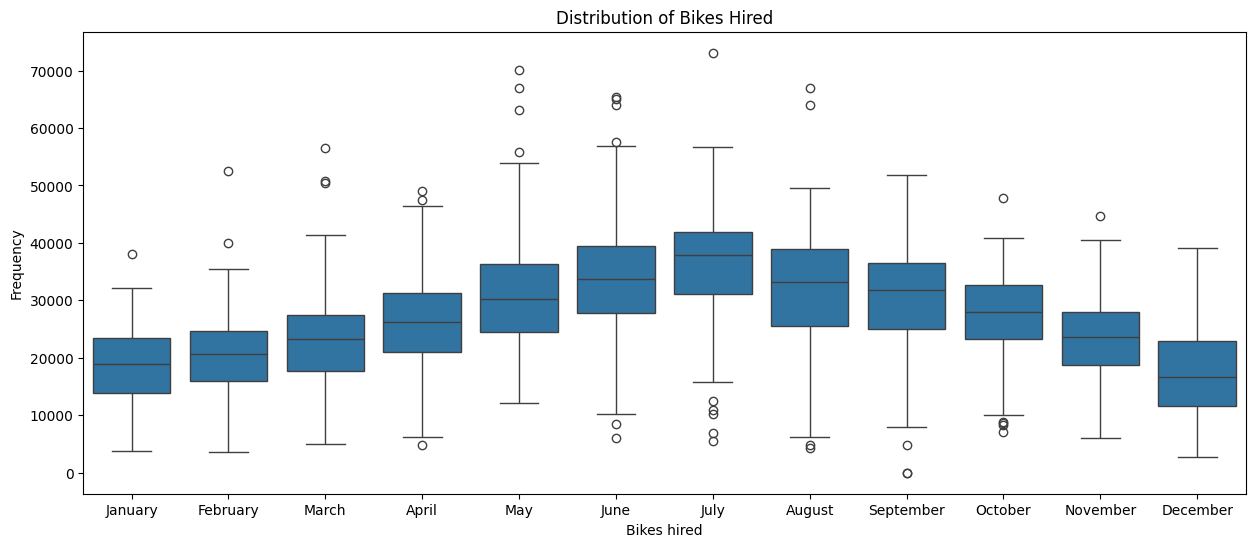

In [10]:
#Distribution of bikes hired by month
plt.figure(figsize=(15, 6))
sns.boxplot(x="month", y="bikes_hired", data=bikes)
plt.title("Distribution of Bikes Hired")
plt.xlabel("Bikes hired")
plt.ylabel("Frequency")
plt.show()


**3. Construct 95% confidence intervals for the mean number of bikes rented per season.**

Repeat the calculation per month.

Interpret the result:

What range of values do you expect the true mean to lie in?

Which seasons/months have higher or lower average demand?

Are there overlaps in the intervals, and what does that mean?

**Deliverables:**

A table or plot showing the mean and confidence intervals.

A short interpretation.

In [11]:
## Your code goes here
# Confidence Interval (CI) using the formula mean +- t_critical * SE

# Observed statistics
month_formula_ci = (
    bikes
    .groupby('season')
    .agg(
        mean_hired=('bikes_hired', 'mean'),
        median_hired=('bikes_hired', 'median'),
        sd_hired=('bikes_hired', 'std'),
        count=('bikes_hired', 'size')
    )
    .reset_index()
)

# Calculate additional statistics for confidence intervals
month_formula_ci['t_critical'] = month_formula_ci['count'].apply(lambda n: stats.t.ppf(0.975, df=n-1))  # t-critical value
month_formula_ci['se_hired'] = month_formula_ci['sd_hired'] / np.sqrt(month_formula_ci['count'])  # Standard error
month_formula_ci['margin_of_error'] = month_formula_ci['t_critical'] * month_formula_ci['se_hired']  # Margin of error
month_formula_ci['hired_low'] = month_formula_ci['mean_hired'] - month_formula_ci['margin_of_error']  # Lower bound
month_formula_ci['hired_high'] = month_formula_ci['mean_hired'] + month_formula_ci['margin_of_error']  # Upper bound

# Sort by mean hired in descending order
month_formula_ci = month_formula_ci.sort_values(by='mean_hired', ascending=False)

# Display the result
month_formula_ci

/tmp/ipykernel_43876/3383890758.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('season')


,season,mean_hired,median_hired,sd_hired,count,t_critical,se_hired,margin_of_error,hired_low,hired_high
2,Summer,33595.457983,34738.0,9156.356507,1190,1.961961,265.429515,520.762400,33074.695583,34116.220383
3,Autumn,27090.992114,27359.5,7817.950352,1268,1.961838,219.549919,430.721395,26660.270718,27521.713509
1,Spring,26585.562185,26425.5,8655.554728,1190,1.961961,250.911996,492.279593,26093.282592,27077.841778
0,Winter,18578.608878,18678.0,6675.942161,1194,1.961954,193.201459,379.052465,18199.556413,18957.661342


**Regression Analysis**

What variables influence the number of bikes rented (y) and how? Build a regression model that best explains the variability in bikes rented.

**Interpret:**

Which predictors are significant?

What do the coefficients mean (in practical terms)?

How much of the variation in bike rentals is explained (R²)?

**Deliverables:**

Regression output table.

A short discussion of which factors matter most for predicting bike rentals.

In [12]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4842 entries, 0 to 4902
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           4842 non-null   datetime64[ns, UTC]
 1   bikes_hired    4842 non-null   int64              
 2   year           4842 non-null   int64              
 3   wday           4842 non-null   object             
 4   month          4842 non-null   category           
 5   week           4842 non-null   int64              
 6   cloud_cover    4842 non-null   float64            
 7   humidity       4842 non-null   float64            
 8   pressure       4842 non-null   float64            
 9   radiation      4842 non-null   float64            
 10  precipitation  4842 non-null   float64            
 11  snow_depth     4842 non-null   float64            
 12  sunshine       4842 non-null   float64            
 13  mean_temp      4842 non-null   float64            
 1

In [14]:
### Your code goes here

# Multiple linear regression model with several predictors
model_clean = smf.ols('bikes_hired ~ mean_temp + sunshine + precipitation + weekend + month + pressure +humidity', data=bikes).fit()
print(model_clean.summary())

                            OLS Regression Results                            
Dep. Variable:            bikes_hired   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     392.8
Date:                Sun, 21 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:23:06   Log-Likelihood:                -49211.
No. Observations:                4842   AIC:                         9.846e+04
Df Residuals:                    4824   BIC:                         9.857e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -7.502e+04   9790

## Deliverables
A knitted HTML, one person per group to submit